<a href="https://colab.research.google.com/github/Negfir/Deep-Learning-HWs/blob/main/HW2/DL_HW2_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


torch.manual_seed(1234)
np.random.seed(1234)

DATASET_SIZE = 5000
batch = 64

In [23]:
#Generating labels
label0 = np.zeros((DATASET_SIZE, 1), dtype=int)
label1 = np.ones((DATASET_SIZE, 1), dtype=int)

#Defining r and t
r = np.random.normal(0, 1, size=(DATASET_SIZE,1))
t = np.random.uniform(0,2*np.pi, size=(DATASET_SIZE,1))

#Class 0 dataset
x0 = np.concatenate((np.cos(t) * r, np.sin(t) * r, label0), axis=1)
#Class 1 dataset
x1 = np.concatenate((np.cos(t) * (r + 5), np.sin(t) * (r + 5), label1), axis=1)

#Concatenating both datasets
dataset = np.concatenate((x0, x1), axis=0)



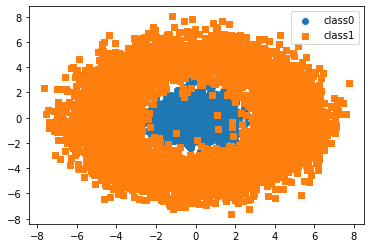

In [24]:
plt.scatter(x0[:,0], x0[:,1], label='class0')
plt.scatter(x1[:,0], x1[:,1], label='class1', marker='s')
plt.legend()
plt.show()

In [25]:
x_data = torch.tensor(dataset[:,0:2],requires_grad=True, dtype = torch.float32)
y_data = torch.tensor(dataset[:,2],dtype = torch.int64)

data = torch.utils.data.TensorDataset(x_data, y_data)
print(len(data))
data_trainset, data_valset = torch.utils.data.random_split(data, lengths=[int(2*DATASET_SIZE*0.8), int(2*DATASET_SIZE*0.2)])

train_data = torch.utils.data.DataLoader(data_trainset, batch_size=batch, shuffle=True)
val_data = torch.utils.data.DataLoader(data_valset, batch_size=batch, shuffle=False)


10000


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [27]:
class Network(nn.Module):
    def __init__(self, n_in, n_hidden):
        super(Network, self).__init__()
        
        self.layer1 = nn.Linear(n_in, n_hidden) #hidden layer
        self.layer2 = nn.Linear(n_hidden, 2) #output layer. Since we have two labels, the size of output is 2. Cross Entropy Loss has been used later to classify the data properly.
    
    def forward(self, x):
        return self.layer2(torch.relu(self.layer1(x)))


Epoch 0: 
Train loss: 0.009183763526380062 train acc: 39.1875
Validation loss: 0.03238772600889206 Validation acc: 47.2000
Epoch 1: 
Train loss: 0.00845499150454998 train acc: 62.1750
Validation loss: 0.027061140164732933 Validation acc: 77.1000
Epoch 2: 
Train loss: 0.007372801657766104 train acc: 82.3625
Validation loss: 0.022969892248511314 Validation acc: 87.0500
Epoch 3: 
Train loss: 0.006500144489109516 train acc: 90.2500
Validation loss: 0.019644485786557198 Validation acc: 92.8000
Epoch 4: 
Train loss: 0.0051321000792086124 train acc: 94.4875
Validation loss: 0.016862090677022934 Validation acc: 95.7500
Epoch 5: 
Train loss: 0.004967003595083952 train acc: 96.3500
Validation loss: 0.014806441962718964 Validation acc: 97.1500
Epoch 6: 
Train loss: 0.004688916727900505 train acc: 97.3625
Validation loss: 0.013107312843203545 Validation acc: 97.7500
Epoch 7: 
Train loss: 0.0034469200763851404 train acc: 97.8500
Validation loss: 0.011829011142253876 Validation acc: 98.1500
Epoch 8:

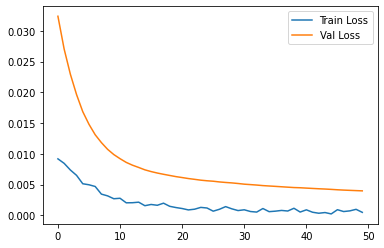

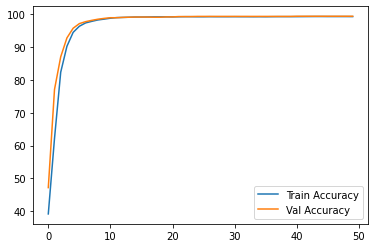

In [28]:
#Initializing the model
model = Network(n_in=2, n_hidden=16).to(device)
#Optimizer setup
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
#We used Cross Entropy Loss instead of Softmax() + NLLLoss for the two class classification task.
criterion = nn.CrossEntropyLoss()

n_epoch = 50
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(n_epoch):
    
    
    
    train_loss = 0.0
    val_loss = 0.0
    number_of_sub_epoch = 0
    correct_t =0
    total_t = 0

    # training loop 
    model.train() # signal train phase
    for x, y in train_data:
        x, y = x.to(device), y.to(device) # move the data to cuda

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_hat = model(x)
        train_loss = criterion(y_hat,y)
        train_loss += train_loss.item() 
        train_loss.backward()
        optimizer.step()
  
        number_of_sub_epoch += 1
        _,pred_t = torch.max(y_hat, dim=1) #predictions
        correct_t += torch.sum(pred_t==y).item() #counting the correct predictions for calculating the accuracy
        total_t += y.size(0)
    train_losses.append(train_loss / number_of_sub_epoch)
    train_acc.append(100 * correct_t / total_t)
    print("Epoch {}: \nTrain loss: {}".format(epoch, train_loss / number_of_sub_epoch), f'train acc: {(100 * correct_t / total_t):.4f}')
    
    number_of_sub_epoch = 0
    correct_t =0
    total_t = 0

    #Evaluation loop
    model.eval()
    with torch.no_grad():
        for x_val,y_val in val_data:
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_hat = model(x_val)
            val_loss = criterion(y_hat, y_val)
            val_loss += val_loss.item()

            number_of_sub_epoch += 1
            _,pred_t = torch.max(y_hat, dim=1)#predictions
            correct_t += torch.sum(pred_t==y_val).item() #counting the correct predictions for calculating the accuracy
            total_t += y_val.size(0)
        val_losses.append(val_loss / number_of_sub_epoch)
        val_acc.append(100 * correct_t / total_t)
    print("Validation loss: {}".format(val_loss / number_of_sub_epoch), f'Validation acc: {(100 * correct_t / total_t):.4f}')



plt.plot(range(n_epoch), train_losses, label='Train Loss')
plt.plot(range(n_epoch), val_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(range(n_epoch), train_acc, label='Train Accuracy')
plt.plot(range(n_epoch), val_acc, label='Val Accuracy')
plt.legend()
plt.show()

In [29]:
#Extracting the values of weights and biases of our trained model
W = model.layer1.weight.cpu().detach().numpy()
bias = model.layer1.bias.cpu().detach().numpy()

x_0 = []
x_1 = []

#Seperating the validarion data based on their label for visualization
for X, Y in val_data:
    for i, y in enumerate(Y):
      if y==1:
        x_1.append(X[i].tolist())
      else:
        x_0.append(X[i].tolist())
x_0 = np.array(x_0)
x_1 = np.array(x_1)

x_0.shape,x_1.shape


((995, 2), (1005, 2))

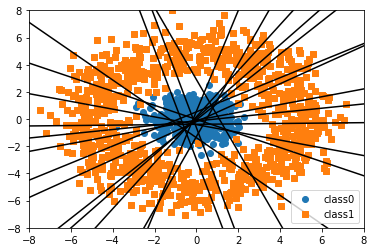

In [30]:

x1 = np.linspace(-100, 100, 1000)
x2 = np.linspace(-100, 100, 1000)


plt.scatter(x_0[:,0], x_0[:,1], label='class0')
plt.scatter(x_1[:,0], x_1[:,1], label='class1', marker='s')
plt.legend()

#plotting the decision boundries of hidden layer by ploting the lines constructed by weights and biases as slope and intercept respectively.
for i,w in enumerate(W):
  plt.plot(w[0]*x1+bias[i], w[1]*x2+bias[i], linestyle='solid',color="black")

plt.axis([-8,8,-8,8])
plt.show()